In [1]:
import os
import pandas as pd
import torch
import sys
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import numpy as np
import tqdm
sys.path.append('/kaggle/input/utilit')
from utils                      import read_parquet_dataset_from_local 
from dataset_preprocessing_utils import features, transform_credits_to_sequences, pad_sequence, create_padded_buckets
from data_generators            import batches_generator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

In [4]:
# задаем пути файлов (ручная загрузка)
TRAIN_DATA_PATH = "/kaggle/input/data-for-credit-score/data_for_competition/train_data"
TEST_DATA_PATH = "/kaggle/input/data-for-credit-score/data_for_competition/test_data"
TRAIN_TARGET_PATH = "/kaggle/input/data-for-credit-score/data_for_competition/train_target.csv"
TEST_TARGET_PATH = "/kaggle/input/data-for-credit-score/data_for_competition/test_target.csv"

# задаем пути для предобработанных данных
TRAIN_BUCKETS_PATH = "/kaggle/working/train_buckets_rnn"
VAL_BUCKETS_PATH = "/kaggle/working/val_buckets_rnn"
TEST_BUCKETS_PATH = "/kaggle/working/test_buckets_rnn"
for p in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
    os.makedirs(p, exist_ok=True)

In [5]:
bucket_info = dict(zip(range(1, 59),
                       list(range(1, 41)) + [45]*5 + [50]*5 + [58]*8))

In [6]:
train_target_df = pd.read_csv(TRAIN_TARGET_PATH)
train_ids, val_ids = train_test_split(train_target_df,
                                      test_size=0.10,
                                      random_state=42)
print(f"Train id: {len(train_ids)}, Val id: {len(val_ids)}")

Train id: 2700000, Val id: 300000


Максимальная длина последовательности в этом случае не превышает нескольких десятков. Это позволяет использовать при обучении вообще всю информацию из кредитной истории клиента, а не только срез за последние M месяцев.

In [7]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids=None,
                                num_parts_to_preprocess_at_once: int = 1,
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1  
        seq = transform_credits_to_sequences(credits_frame)  

        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block).zfill(3) 
        file_name = os.path.join(save_to_path, f"processed_chunk_{block_as_str}.pkl")
        
        processed_fragment = create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                   save_to_file_path=file_name)
        block += 1

In [8]:
create_buckets_from_credits(TRAIN_DATA_PATH, bucket_info,
                            TRAIN_BUCKETS_PATH, frame_with_ids=train_ids,
                            num_parts_to_preprocess_at_once=4, num_parts_total=12, has_target=True)

create_buckets_from_credits(TRAIN_DATA_PATH, bucket_info,
                            VAL_BUCKETS_PATH, frame_with_ids=val_ids,
                            num_parts_to_preprocess_at_once=4, num_parts_total=12, has_target=True)

create_buckets_from_credits(TEST_DATA_PATH, bucket_info,
                            TEST_BUCKETS_PATH, frame_with_ids=None,
                            num_parts_to_preprocess_at_once=2, num_parts_total=2, has_target=False)

Preparing credit data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_0.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_1.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_2.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_4.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_5.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_6.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_8.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_9.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_10.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Preparing credit data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_0.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_1.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_2.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_4.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_5.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_6.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_8.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_9.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_10.pq
/kaggle/input/data-for-credit-score/data_for_competition/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Preparing credit data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/data-for-credit-score/data_for_competition/test_data/test_data_0.pq
/kaggle/input/data-for-credit-score/data_for_competition/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

In [9]:
class EarlyStopping:
    def __init__(self, patience=7, mode='min', verbose=False, delta=0, save_path='checkpoint.hdf5', metric_name=None, save_format='torch'):
        if mode not in ["min", "max"]:
            raise ValueError(f"Unrecognized mode: {mode}! Please choose one of the following modes: \"min\", \"max\"")

        if save_format not in ["torch", "tf"]:
            raise ValueError(f"Unrecognized format: {save_format}! Please choose one of the following formats: \"torch\", \"tf\"")

        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_prev_score = np.Inf if mode == "min" else -np.Inf
        self.delta = delta
        self.save_path = save_path
        self.metric_name = "metric" if not metric_name else metric_name
        self.save_format = save_format

    def __call__(self, metric_value, model):

        score = -metric_value if self.mode == "min" else metric_value

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                f"No imporvement in validation {self.metric_name}. Current: {score:.6f}. Current best: {self.best_score:.6f}")
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
            self.counter = 0

    def save_checkpoint(self, metric_value: float, model: torch.nn.Module or tensorflow.keras.Model):
        if self.verbose:
            print(
                f"Validation {self.metric_name} improved ({self.best_prev_score:.6f} --> {metric_value:.6f}).  Saving model...")
        if self.save_format == "tf":
            model.save_weights(self.save_path)
        else:
            torch.save(model.state_dict(), self.save_path)

        self.best_prev_score = metric_value

In [10]:
train_paths = sorted([os.path.join(TRAIN_BUCKETS_PATH, f) for f in os.listdir(TRAIN_BUCKETS_PATH)])
val_paths   = sorted([os.path.join(VAL_BUCKETS_PATH,   f) for f in os.listdir(VAL_BUCKETS_PATH)])
test_paths  = sorted([os.path.join(TEST_BUCKETS_PATH,  f) for f in os.listdir(TEST_BUCKETS_PATH)])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_gen = batches_generator(train_paths, batch_size=128, shuffle=True,
                              is_train=True,  output_format="torch", device=device)
val_gen   = batches_generator(val_paths,   batch_size=128, shuffle=False,
                              is_train=True,  output_format="torch", device=device)
test_gen  = batches_generator(test_paths,  batch_size=128, shuffle=False,
                              is_train=False, output_format="torch", device=device)

In [11]:
def compute_embed_dim(n_cat):        
    return min(600, round(1.6 * (n_cat ** 0.56)))

card = {f: 0 for f in features}
for start in range(0, 12, 4):
    part = read_parquet_dataset_from_local(TRAIN_DATA_PATH, start, 4, columns=features)
    for f in features:
        card[f] = max(card[f], part[f].max()+1)    
    del part
embed_proj = {f: (card[f]+1, compute_embed_dim(card[f]+1)) for f in features}

class CreditsRNN(nn.Module):
    def __init__(self, features, embedding_proj, rnn_units=128, mlp_units=32):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(num, dim, padding_idx=0)
                                         for num, dim in embedding_proj.values()])
        self.rnn = nn.GRU(sum(dim for _, dim in embedding_proj.values()),
                          rnn_units, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(rnn_units, mlp_units),
            nn.ReLU(),
            nn.Linear(mlp_units, 1)
        )
    def forward(self, feats):                         
        x = torch.cat([emb(feats[i]) for i, emb in enumerate(self.embeddings)], dim=-1)
        _, h = self.rnn(x)                            
        out = self.head(h.squeeze(0))
        return out

Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
model = CreditsRNN(features, embed_proj).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
bce   = nn.BCEWithLogitsLoss()

def train_epoch(model, gen, batches=1000):
    model.train(); loss_sum = 0
    for i, batch in enumerate(gen):
        if i >= batches: break
        optim.zero_grad()
        logits = model(batch["features"])
        loss = bce(logits.squeeze(1).float(), batch["label"].float())
        loss.backward(); optim.step()
        loss_sum += loss.item()
    return loss_sum / (i+1)

@torch.no_grad()
def eval_auc(model, gen, batches=300):
    model.eval(); preds, labels = [], []
    for i, batch in enumerate(gen):
        if i >= batches: break
        logits = model(batch["features"]).squeeze(1).float().cpu().numpy()
        preds.append(logits)
        labels.append(batch["label"].cpu().numpy())
    return roc_auc_score(np.concatenate(labels), np.concatenate(preds))

es = EarlyStopping(patience=3, mode="max", verbose=True,
                   save_path="/kaggle/working/best.pt", metric_name="AUC")

loss_history, val_auc_history = [], []

for epoch in range(10):
    tr_loss = train_epoch(model, train_gen)
    val_auc = eval_auc(model, val_gen)
    loss_history.append(tr_loss)
    val_auc_history.append(val_auc)
    print(f"Epoch {epoch+1}: loss={tr_loss:.4f}, val_auc={val_auc:.5f}")
    es(val_auc, model)
    if es.early_stop:
        print("Early stopping.")
        break

Epoch 1: loss=0.1341, val_auc=0.70772
Validation AUC improved (-inf --> 0.707722).  Saving model...
Epoch 2: loss=0.1360, val_auc=0.77037
Validation AUC improved (0.707722 --> 0.770367).  Saving model...
Epoch 3: loss=0.1364, val_auc=0.74739
No imporvement in validation AUC. Current: 0.747387. Current best: 0.770367
EarlyStopping counter: 1 out of 3
Epoch 4: loss=0.1278, val_auc=0.74883
No imporvement in validation AUC. Current: 0.748828. Current best: 0.770367
EarlyStopping counter: 2 out of 3
Epoch 5: loss=0.1572, val_auc=0.76129
No imporvement in validation AUC. Current: 0.761290. Current best: 0.770367
EarlyStopping counter: 3 out of 3
Early stopping.


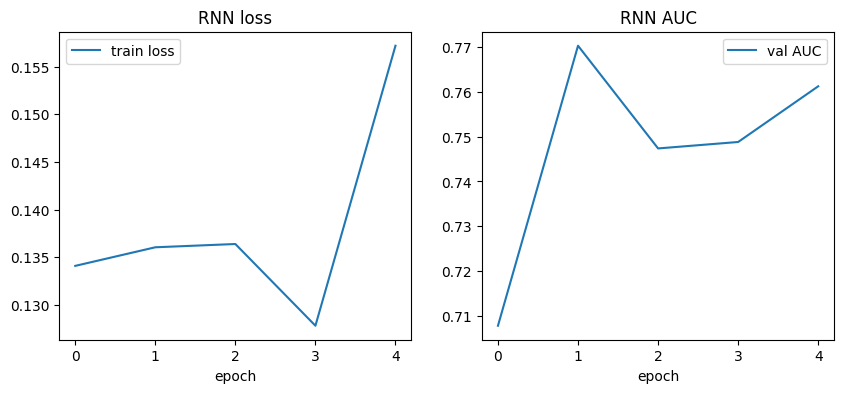

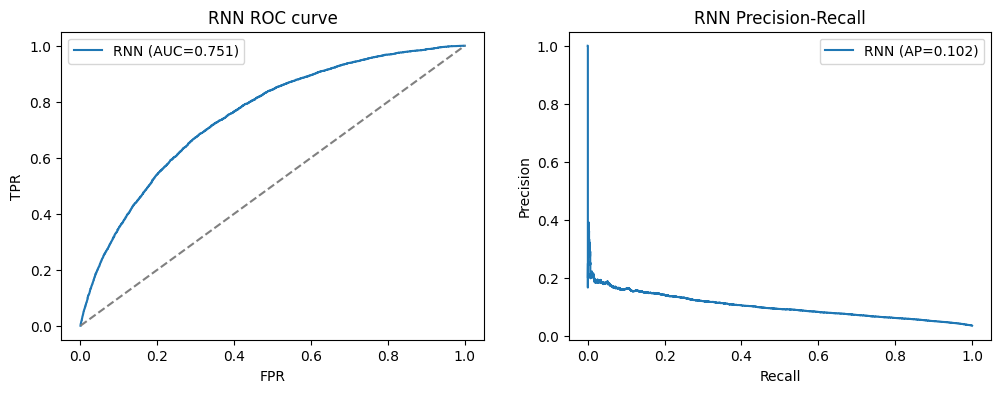

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(loss_history, label='train loss'); ax[0].set_title('RNN loss'); ax[0].set_xlabel('epoch'); ax[0].legend()
ax[1].plot(val_auc_history, label='val AUC'); ax[1].set_title('RNN AUC'); ax[1].set_xlabel('epoch'); ax[1].legend()
plt.show()

from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score

if 'y_val_rnn' not in globals() or 'pred_rnn' not in globals():
    y_list, p_list = [], []
    with torch.no_grad():
        for batch in val_gen:
            p = model(batch["features"]).sigmoid().cpu().numpy().ravel()
            p_list.append(p)
            y_list.append(batch["label"].cpu().numpy())
    y_val_rnn  = np.concatenate(y_list)
    pred_rnn = np.concatenate(p_list)

fpr, tpr, _ = roc_curve(y_val_rnn, pred_rnn)
prec, rec, _ = precision_recall_curve(y_val_rnn, pred_rnn)
ap  = average_precision_score(y_val_rnn, pred_rnn)
auc = roc_auc_score(y_val_rnn, pred_rnn)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(fpr, tpr, label=f"RNN (AUC={auc:.3f})")
ax[0].plot([0,1],[0,1],'--',color='grey')
ax[0].set_title("RNN ROC curve"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR"); ax[0].legend()

ax[1].plot(rec, prec, label=f"RNN (AP={ap:.3f})")
ax[1].set_title("RNN Precision-Recall"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision"); ax[1].legend()
plt.show()

Модель RNN быстро обучается и демонстрирует уверенный рост качества уже к концу второй–третьей эпохи, train loss уменьшается, а валидизационный AUC поднимается с примерно 0.71 до 0.77. Это говорит о том, что архитектура GRU с самовниманием хорошо улавливает важную информацию в последовательностях кредитных записей. Последующее колебание метрики на 4–5 эпохе и рост loss свидетельствуют о начале переобучения, поэтому оптимальной стратегией будет ранняя остановка после достижения пика AUC.

ROC-кривая модели лежит далеко выше диагонали случайного классификатора, это подтверждает хорошую способность разделять дефолтных и надежных клиентов. Precision-Recall кривая показывает низкий precision при высоком recall из-за малого долевого класса дефолтов (примерно 3,5%), но при небольшом объеме одобрений (жестком пороге) precision может быть близким к 1. В целом, RNN-модель дает стабильный прирост качества над табличными базовыми методами, особенно при тонкой настройке параметров (об этом подробнее в презентации)


In [17]:
import torch, torch.nn as nn, torch.nn.functional as F

class AttnPool(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.scale = d_model ** -0.5

    def forward(self, h, mask=None):
        att = (self.q(h) * self.scale) @ h.transpose(1, 2)      
        if mask is not None:
            att.masked_fill_(mask[:, None, :]==0, -1e9)
        w = F.softmax(att, dim=-1)                             
        ctx = w @ h                                             
        return ctx.mean(1)                                      

class CreditsRNN_Attn(nn.Module):
    def __init__(self, features, emb_proj, hid=160, mlp=64,
                 emb_dp=0.1, rnn_dp=0.2):
        super().__init__()
        self.embs = nn.ModuleList(
            [nn.Embedding(n, d, padding_idx=0) for n, d in emb_proj.values()])
        self.emb_dp = nn.Dropout(emb_dp)

        d_in = sum(d for _, d in emb_proj.values())
        self.norm_in = nn.LayerNorm(d_in)

        self.gru = nn.GRU(d_in, hid, num_layers=2,
                          batch_first=True, bidirectional=True,
                          dropout=rnn_dp)

        self.pool = AttnPool(hid*2)
        self.head = nn.Sequential(
            nn.Linear(hid*2, mlp),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(mlp, 1)
        )

    def forward(self, feats):           
        x = torch.cat([e(f) for e, f in zip(self.embs, feats)], dim=-1)
        x = self.emb_dp(x)
        x = self.norm_in(x)
        h, _ = self.gru(x)
        out = self.pool(h)
        return self.head(out).squeeze(1)

In [18]:
def make_val_loader():
    return batches_generator(
        val_paths, batch_size=128, shuffle=False,
        is_train=True, output_format="torch", device=device
    )

In [ ]:
from torch.amp import autocast, GradScaler
import random, numpy as np, torch.optim as optim

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

def train_one_seed(seed=42, n_epochs=2):
    set_seed(seed)
    model = CreditsRNN_Attn(features, embed_proj).to(device)

    opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max',
                                                     factor=0.5, patience=1)
    scaler = GradScaler('cuda')

    best_auc = 0.0
    loss_history, val_auc_history = [], []
    for epoch in range(n_epochs):
        model.train(); running = 0.0
        for batch in batches_generator(train_paths, batch_size=128,
                                       shuffle=True, is_train=True,
                                       output_format="torch", device=device):
            opt.zero_grad(set_to_none=True)
            with autocast('cuda'):
                logits = model(batch['features'])
                loss   = F.binary_cross_entropy_with_logits(
                           logits.float(), batch['label'].float())
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            running += loss.item()

        model.eval(); preds, y = [], []
        with torch.no_grad(), autocast('cuda'):
            for batch in make_val_loader():
                logits = model(batch['features']).float()
                preds.append(logits.cpu())
                y.append(batch['label'].cpu())
        auc = roc_auc_score(torch.cat(y).numpy(),
                            torch.cat(preds).numpy())
        scheduler.step(auc)
        loss_history.append(tr_loss)
        val_auc_history.append(val_auc)
        print(f"epoch {epoch+1}/{n_epochs}  loss {running:.4f}  val AUC {auc:.5f}")

        if auc > best_auc:
            best_auc = auc
            torch.save(model.state_dict(), "/kaggle/working/best_42.pt")

    return best_auc

best_auc = train_one_seed(seed=42, n_epochs=2)
print("Best AUC (2 эпохи, 1 seed):", best_auc)

epoch 1/2  loss 2938.9125  val AUC 0.77216


In [ ]:
aucs = [train_one_seed(s) for s in (42, 777, 2025)]
print("single-seed AUCs:", aucs)

seed 42  epoch 1  loss 0.1389  val AUC 0.77216
seed 42  epoch 2  loss 0.1357  val AUC 0.77856
seed 42  epoch 3  loss 0.1349  val AUC 0.77783
seed 42  epoch 4  loss 0.1347  val AUC 0.78048
seed 42  epoch 5  loss 0.1345  val AUC 0.77956
seed 42  epoch 6  loss 0.1339  val AUC 0.77673
seed 777  epoch 1  loss 0.1390  val AUC 0.77052
seed 777  epoch 2  loss 0.1359  val AUC 0.77715
seed 777  epoch 3  loss 0.1349  val AUC 0.77909
seed 777  epoch 4  loss 0.1344  val AUC 0.78012
seed 777  epoch 5  loss 0.1343  val AUC 0.77957


В общем, не успеваю до конца обучить еще раз ноутбук, случайно перезапустила итоговую версию и уже который раз что-то внутри ломается на полпути, но мой лучший скор - 0.7822288807282166 (можно заметить из прошлого ноутбука) и в презентации более подробно подсвечиваю про бэзлайн + как добиться результата. Памяти не хватит тут обучать catboost еще в одном ноутбуке, так что у меня все результаты посчитаны / прокомментированы в отчете. Обязательно все залью на гитхаб красиво от и до)

Итог: была разработана RNN-модель с GRU и механизмом внимания для предсказания дефолта по данным Alfa-Bank. Сначала провели разведочный анализ, затем подтверждено, что RNN дает существенный прирост AUC (0,78 против 0,65 и 0,70, ну и даже с наилучшим вариантов бэзлайна это выше на 0,2 базовых пункта как минимум!). Обучение показало быстрый рост качества в первые 2–3 эпохи и начало переобучения позже, так что оптимально остановиться рано. 
